# Gaussian Processes from scratch

Loading the Data
First, we need to load the dataset that we'll use for training and testing the GP model. Here, we're using the UCI Machine Learning Repository's "bike" dataset, and using only the last feature so that the predictions can be easily visualized.

In [1]:
!wget -O bike.mat "https://www.andpotap.com/static/bike.mat"

--2023-10-13 14:55:46--  https://www.andpotap.com/static/bike.mat
Resolving www.andpotap.com (www.andpotap.com)... 143.42.238.119
Connecting to www.andpotap.com (www.andpotap.com)|143.42.238.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 434829 (425K) [application/octet-stream]
Saving to: ‘bike.mat’

bike.mat            100%[===================>] 424.64K  --.-KB/s    in 0.05s   

2023-10-13 14:55:46 (8.22 MB/s) - ‘bike.mat’ saved [434829/434829]



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from jax import numpy as jnp
import os
import numpy as np
from math import floor
from scipy.io import loadmat
import cola


def load_uci_data(data_dir, dataset, train_p=0.75, test_p=0.15):
    file_path = os.path.join(data_dir, dataset + '.mat')
    data = np.array(loadmat(file_path)['data'])
    X = data[:, -2:-1]
    y = data[:, -1]
    X = X - X.min(0)[None]
    X = 2.0 * (X / X.max(0)[None]) - 1.0
    y -= y.mean()
    y /= y.std()
    train_n = int(floor(train_p * X.shape[0]))
    return X[:train_n], y[:train_n], X[train_n:], y[train_n:]


train_x, train_y, test_x, test_y = load_uci_data(data_dir="./", dataset="bike")
dtype = jnp.float32
train_x  = train_x[:3000]
train_y  = train_y[:3000]

In [4]:
def rbf(ls, uscale):
    def f(x, y):
        # (n, d) and (m, d) -> (n, m)
        inner = x@y.T
        sqdist = (x**2).sum(1).reshape(-1, 1) + (y**2).sum(1) - 2*inner
        return uscale*jnp.exp(-sqdist / ls**2)
    return f

For a Gaussian Process, the predictive distribution of the function values at test inputs $X_*$
  given the training inputs 
$X$ and training targets 
$y$ is given by:

$$f_* | X, y, X_* \sim \mathcal{N}(\mu_*, \Sigma_*)$$

where:

$$\mu_* = K(X_*, X)[K(X, X) + \sigma^2_n I]^{-1}y$$

$$\Sigma_* = K(X_*, X_*) - K(X_*, X)[K(X, X) + \sigma^2_n I]^{-1}K(X, X_*)$$

Here, $K$ is the RBF kernel, $X$ are the training inputs, $y$ are the training targets, $X_*$ are the test inputs, and $\sigma^2_n$ is the noise variance.

We will get the variances from the diagonal of the predictive covariance.

In [6]:
from cola.linalg import Cholesky

ls, uscale, noise = .2, .5, 1e-2

def predicted_mean_std(ls,uscale,noise):
    kernel = rbf(ls=ls, uscale=uscale)
    Kxx= cola.ops.Dense(kernel(train_x, train_x))
    Kzx = cola.ops.Dense(kernel(test_x, train_x))
    Kzz = cola.ops.Dense(kernel(test_x, test_x))
    K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
    invK = cola.inv(K, alg=Cholesky())
    mu = Kzx@invK@train_y
    Sigma = Kzz - Kzx@invK@Kzx.T
    std = jnp.sqrt(cola.diag(Sigma))
    return mu,std

### Visualization
Next, we visualize the GP's prediction with the initial hyperparameters:

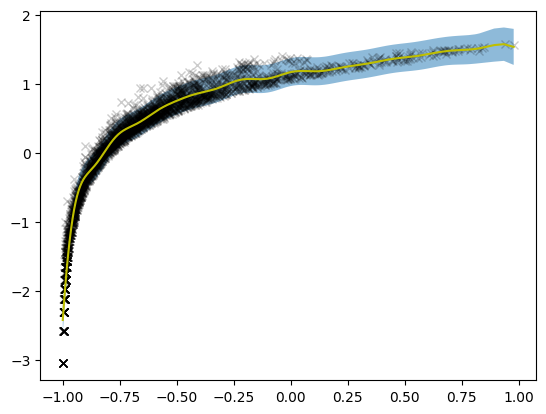

In [8]:
import matplotlib.pyplot as plt
mu, std = predicted_mean_std(ls,uscale,noise)
pstd = np.sqrt(std**2+noise) # prediction interval std
order = np.argsort(test_x.reshape(-1))
plt.plot(train_x.reshape(-1), train_y, 'kx', alpha=.2)
plt.plot(test_x[order].reshape(-1), mu[order], 'y')
plt.fill_between(test_x[order].reshape(-1), (mu - 2*pstd)[order], (mu + 2*pstd)[order], alpha=.5, interpolate=True)

As you can see, we have chosen the noise value too small for the data.
But lets fix that by optimizing these parameters using the marginal log likelihood

## Hyperparameter Optimization
Often, the initial hyperparameter values may not fit the data well. We can optimize these parameters using the marginal log-likelihood:

$$
\text{NLL} = \frac{1}{2} y^T (K + \sigma^2_n I)^{-1} y + \frac{1}{2} \log |K + \sigma^2_n I| + \frac{n}{2} \log 2\pi
$$

Here:

- $y$ is the vector of target values.
- $K$ is the kernel matrix computed using the RBF kernel between the training inputs.
- $\sigma^2_n$ is the noise variance.
- $I$ is the identity matrix.
- $n$ is the number of training examples.

In [13]:
# compute the MLL
y = train_y
alg = Cholesky()
def NLL(params, key):
    ls,uscale,noise = params
    kernel = rbf(ls, uscale)
    Kxx= cola.ops.Dense(kernel(train_x, train_x))
    K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
    invK = cola.inv(K,alg)
    minus2MLL =y.T@(invK@y)+cola.logdet(K,alg)+jnp.log(2*jnp.pi)*y.shape[0]
    return minus2MLL/(2*y.shape[0])

Using optax and jax, we create a training loop to optimize the hyperparameters:

In [14]:
import optax
import jax
# create the training loop
opt = optax.adam(3e-3)

@jax.jit
def step(params,opt_state, key):
    loss, grads = jax.value_and_grad(NLL)(params, key)
    key = jax.random.split(key)[0]
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, key

params = list(map(jnp.array,(ls,uscale,noise)))
opt_state = opt.init(params)
key = jax.random.PRNGKey(0)
for i in range(10):
    params,opt_state,loss,key = step(params,opt_state,key)
    print(f"loss: {loss.item():.3f}")

loss: -0.268
loss: -0.377
loss: -0.423
loss: -0.443
loss: -0.451
loss: -0.454
loss: -0.454
loss: -0.454
loss: -0.453
loss: -0.453


Now we have a new lengthscale, uncertainty scale and noise level.

In [15]:
ls, uscale, noise = params
print(f"ls = {ls:.2f}, uscale = {uscale:.2f}, noise = {noise:.2f}")

ls = 0.17, uscale = 0.53, noise = 0.03


### Final Visualization
Finally, we visualize the GP's prediction with the optimized hyperparameters. The new plot shows a better fit to the data:

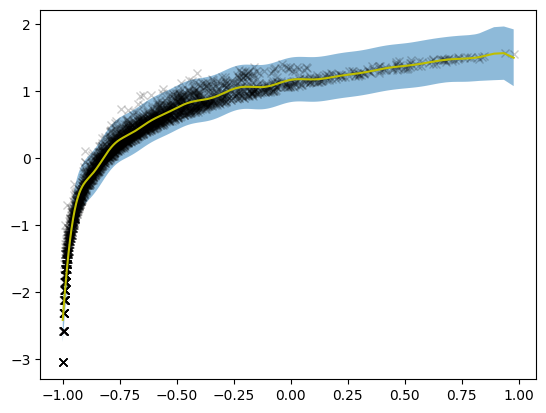

In [16]:
import matplotlib.pyplot as plt

mu, std = predicted_mean_std(ls,uscale,noise)
pstd = np.sqrt(std**2+noise) # prediction interval std
order = np.argsort(test_x.reshape(-1))
plt.plot(train_x.reshape(-1), train_y, 'kx', alpha=.2)
plt.plot(test_x[order].reshape(-1), mu[order], 'y')
plt.fill_between(test_x[order].reshape(-1), (mu - 2*pstd)[order], (mu + 2*pstd)[order], alpha=.5, interpolate=True)